# Emulators: First example

This example illustrates Bayesian inference on a time series, using [Adaptive Covariance MCMC](http://pints.readthedocs.io/en/latest/mcmc_samplers/adaptive_covariance_mcmc.html) with emulator neural networks .

It follows on from [Sampling: First example](../sampling/first-example.ipynb)

Like in the sampling example, I start by importing pints:

In [1]:
import pints

C:\Users\plagl\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\plagl\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\plagl\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\plagl\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passi

In [2]:
def histogram(
        samples,
        kde=False,
        n_percentiles=None,
        parameter_names=None,
        ref_parameters=None,
        sample_names=None):
    """
    Takes one or more markov chains or lists of samples as input and creates
    and returns a plot showing histograms for each chain or list of samples.
    Returns a ``matplotlib`` figure object and axes handle.
    Parameters
    ----------
    samples
        A list of lists of samples, with shape
        ``(n_lists, n_samples, n_parameters)``, where ``n_lists`` is the
        number of lists of samples, ``n_samples`` is the number of samples in
        one list and ``n_parameters`` is the number of parameters.
    kde
        Set to ``True`` to include kernel-density estimation for the
        histograms.
    n_percentiles
        Shows only the middle n-th percentiles of the distribution.
        Default shows all samples in ``samples``.
    parameter_names
        A list of parameter names, which will be displayed on the x-axis of the
        histogram subplots. If no names are provided, the parameters are
        enumerated.
    ref_parameters
        A set of parameters for reference in the plot. For example, if true
        values of parameters are known, they can be passed in for plotting.
    """
    import matplotlib
    import matplotlib.pyplot as plt

    # Check matplotlib version
    use_old_matplotlib = LooseVersion(matplotlib.__version__) \
        < LooseVersion("2.2")

    # If we switch to Python3 exclusively, bins and alpha can be keyword-only
    # arguments
    bins = 40
    alpha = 0.5
    n_list = len(samples)
    _, n_param = samples[0].shape

    # Check parameter names
    if parameter_names is None:
        parameter_names = ['Parameter' + str(i + 1) for i in range(n_param)]
    elif len(parameter_names) != n_param:
        raise ValueError(
            'Length of `parameter_names` must be same as number of'
            ' parameters.')

    # Check number of parameters
    for samples_j in samples:
        if n_param != samples_j.shape[1]:
            raise ValueError(
                'All samples must have the same number of parameters.'
            )

    # Check reference parameters
    if ref_parameters is not None:
        if len(ref_parameters) != n_param:
            raise ValueError(
                'Length of `ref_parameters` must be same as number of'
                ' parameters.')

    # Set up figure
    fig, axes = plt.subplots(
        n_param, 1, figsize=(6, 2 * n_param),
        squeeze=False,    # Tell matlab to always return a 2d axes object
    )

    # Plot first samples
    for i in range(n_param):
        for j_list, samples_j in enumerate(samples):
            # Add histogram subplot
            axes[i, 0].set_xlabel(parameter_names[i])
            axes[i, 0].set_ylabel('Frequency')
            if n_percentiles is None:
                xmin = np.min(samples_j[:, i])
                xmax = np.max(samples_j[:, i])
            else:
                xmin = np.percentile(samples_j[:, i],
                                     50 - n_percentiles / 2.)
                xmax = np.percentile(samples_j[:, i],
                                     50 + n_percentiles / 2.)
            xbins = np.linspace(xmin, xmax, bins)
            if sample_names is not None:
                label=sample_names[j_list]
            else:
                label='Samples ' + str(1 + j_list)
            if use_old_matplotlib:  # pragma: no cover
                axes[i, 0].hist(
                    samples_j[:, i], bins=xbins, alpha=alpha, normed=True,
                    label=label)
            else:
                axes[i, 0].hist(
                    samples_j[:, i], bins=xbins, alpha=alpha, density=True,
                    label=label)

            # Add kde plot
            if kde:
                x = np.linspace(xmin, xmax, 100)
                axes[i, 0].plot(x, stats.gaussian_kde(samples_j[:, i])(x))

        # Add reference parameters if given
        if ref_parameters is not None:
            # For histogram subplot
            ymin_tv, ymax_tv = axes[i, 0].get_ylim()
            axes[i, 0].plot(
                [ref_parameters[i], ref_parameters[i]],
                [0.0, ymax_tv],
                '--', c='k')
    if n_list > 1:
        axes[0, 0].legend()

    plt.tight_layout()
    return fig, axes[:, 0]

In [3]:
def surface(
        x_grid, y_grid, z_grid,
        cmap="Blues", angle=(25, 300), alpha=1.,
        fontsize=14, labelpad=10,
        title="", x_label="", y_label="", z_label="log_likelihood"):
    """
    Creates 3d contour plot given a grid for each axis.
    Arguments:
    ``x_grid``
        An NxN grid of values.
    ``y_grid``
        An NxN grid of values.
    ``z_grid``
        An NxN grid of values. z_grid determines colour.
    ``cmap``
        (Optional) Colour map used in the plot
    ``angle``
        (Optional) tuple specifying the viewing angle of the graph
    ``alpha``
        (Optional) alpha parameter of the surface
    ``fill``
        (Optional) Used to specify whether or not contour plot should be filled
        Default False.
    ``fontsize``
        (Optional) the fontsize used for labels
    ``labelpad``
        (Optional) distance of axis labels from the labels
    ``x_label``
        (Optional) The label of the x-axis
    ``y_label``
        (Optional) The label of the y-axis
    ``z_label``
        (Optional) The label of the z-axis
    Returns a ``matplotlib`` figure object and axes handle.
    """
    import matplotlib.pyplot as plt
    from mpl_toolkits.mplot3d import Axes3D 
    ax = plt.axes(projection='3d')
    # Data for a three-dimensional line
    ax.plot_surface(x_grid, y_grid, z_grid, cmap=cmap, alpha=alpha)
    ax.view_init(*angle)

    fontsize = fontsize
    labelpad = labelpad

    if title:
        plt.title(title, fontsize=fontsize)
    if x_label:
        ax.set_xlabel(x_label, fontsize=fontsize, labelpad=labelpad)
    if y_label:
        ax.set_ylabel(y_label, fontsize=fontsize, labelpad=labelpad)
    if z_label:
        ax.set_zlabel(z_label, fontsize=fontsize, labelpad=labelpad)

    return ax

Next, I create a model class using the "Logistic" toy model included in pints:

In [4]:
import pints.toy as toy
model = toy.LogisticModel()

In order to generate some test data, I choose an arbitrary set of "true" parameters:

In [5]:
true_parameters = [0.015, 500]

And a number of time points at which to sample the time series:

In [6]:
import numpy as np
times = np.linspace(0, 1000, 400)

Using these parameters and time points, I generate an example dataset:

In [7]:
org_values = model.simulate(true_parameters, times)

And make it more realistic by adding gaussian noise:

In [8]:
noise = 5
values = org_values + np.random.normal(0, noise, org_values.shape)

Using matplotlib, I look at the noisy time series I just simulated:

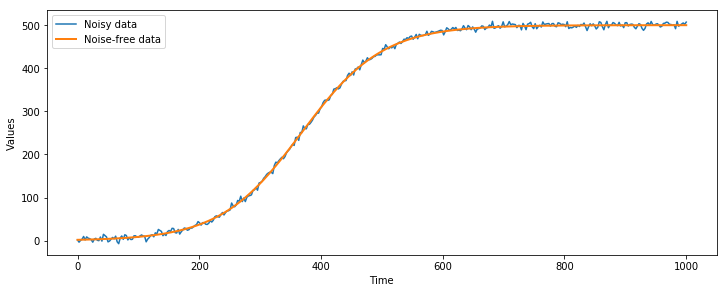

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,4.5))
plt.xlabel('Time')
plt.ylabel('Values')
plt.plot(times, values, label='Noisy data')
plt.plot(times, org_values, lw=2, label='Noise-free data')
plt.legend()
plt.show()

Now, I have enough data (a model, a list of times, and a list of values) to formulate a PINTS problem:

In [10]:
problem = pints.SingleOutputProblem(model, times, values)

I now have some toy data, and a model that can be used for forward simulations. To make it into a probabilistic problem, a _noise model_ needs to be added. This can be done using the `GaussianLogLikelihood` function, which assumes independently distributed Gaussian noise over the data, and can calculate log-likelihoods:

In [11]:
#log_likelihood = pints.GaussianLogLikelihood(problem)
log_likelihood = pints.GaussianKnownSigmaLogLikelihood(problem, noise)

The resulting noise has mean zero and an unknown standard deviation. The standard deviation can be inferred along with the other parameters, meaning the number of parameters of the problem increased by one!

In [12]:
print('Original number of parameters: ' + str(problem.n_parameters()))

Original number of parameters: 2


In [13]:
print('New number of parameters: ' + str(log_likelihood.n_parameters()))

New number of parameters: 2


This means the vector of true parameters has to be updated:

In [14]:
#true_parameters += [noise]
print(true_parameters)

[0.015, 500]


This `log_likelihood` represents the _conditional probability_ $p(y|\theta)$, given a set of parameters $\theta$ and a series of $y=$ `values`, it can calculate the probability of finding those values if the real parameters are $\theta$.

This can be used in a Bayesian inference scheme to find the quantity of interest:

$p(\theta|y) = \frac{p(\theta)p(y|\theta)}{p(y)} \propto p(\theta)p(y|\theta)$

To solve this, a _prior_ is defined, indicating an initial guess about what the parameters should be. 
Similarly as using a _log-likelihood_ (the natural logarithm of a likelihood), this is defined by using a _log-prior_. Hence, the above equation simplifies to:

$\log p(\theta|y) \propto \log p(\theta) + \log p(y|\theta)$

In this example, it is assumed that we don't know too much about the prior except lower and upper bounds for each variable: We assume the first model parameter is somewhere on the interval $[0.01, 0.02]$, the second model parameter on $[400, 600]$, and the standard deviation of the noise is somewhere on $[1, 100]$.

In [15]:
# Create bounds for our parameters and get prior
bounds = pints.RectangularBoundaries([0.01, 400], [0.02, 600])
log_prior = pints.UniformLogPrior(bounds)

With this prior, the numerator of Bayes' rule can be defined -- the unnormalised log posterior, $\log \left[ p(y|\theta) p(\theta) \right]$, which is the natural logarithm of the likelihood times the prior:

In [16]:
# Create a posterior log-likelihood (log(likelihood * prior))
log_posterior = pints.LogPosterior(log_likelihood, log_prior)

Finally we create a list of guesses to use as initial positions. We'll run three MCMC chains so we create three initial positions:

In [17]:
xs = [
    np.array(true_parameters) * 0.9,
    np.array(true_parameters) * 1.05,
    np.array(true_parameters) * 1.15,
]

And this gives us everything we need to run an MCMC routine:

In [18]:
chains = pints.mcmc_sample(log_posterior, 3, xs)

Using Haario-Bardenet adaptive covariance MCMC
Generating 3 chains.
Running in sequential mode.
Iter. Eval. Accept.   Accept.   Accept.   Time m:s
0     3      0         0         0          0:00.0
1     6      0         0         0          0:00.8
2     9      0         0         0          0:00.8
3     12     0         0         0.25       0:00.8
20    63     0.143     0.0952    0.19       0:00.8
40    123    0.0976    0.0488    0.0976     0:00.8
60    183    0.0656    0.0328    0.082      0:00.9
80    243    0.0494    0.0247    0.0617     0:00.9
100   303    0.0495    0.0198    0.0495     0:00.9
120   363    0.0413    0.0165    0.0413     0:00.9
140   423    0.0355    0.0142    0.0426     0:00.9
160   483    0.0311    0.0124    0.0373     0:00.9
180   543    0.0276    0.0166    0.0387     0:00.9
Initial phase completed.
200   603    0.0249    0.0149    0.039801   0:00.9
220   663    0.0407    0.0226    0.0452     0:00.9
240   723    0.0747    0.0207    0.0747     0:01.0
260   783   

3160  9483   0.242     0.255299  0.258      0:03.0
3180  9543   0.242691  0.254     0.256      0:03.0
3200  9603   0.242     0.254     0.256      0:03.1
3220  9663   0.243     0.253     0.255      0:03.1
3240  9723   0.243     0.254     0.255      0:03.1
3260  9783   0.245     0.254     0.255      0:03.1
3280  9843   0.245352  0.256     0.254      0:03.1
3300  9903   0.246     0.257     0.255      0:03.1
3320  9963   0.246     0.258     0.255      0:03.1
3340  10023  0.247     0.258     0.254      0:03.2
3360  10083  0.246     0.257     0.254      0:03.2
3380  10143  0.245     0.257     0.253      0:03.2
3400  10203  0.244928  0.256     0.252      0:03.2
3420  10263  0.246     0.254     0.251      0:03.2
3440  10323  0.245     0.253     0.252      0:03.2
3460  10383  0.246     0.253395  0.252      0:03.3
3480  10443  0.246     0.254     0.252      0:03.3
3500  10503  0.246     0.253     0.252      0:03.3
3520  10563  0.245     0.252     0.252      0:03.3
3540  10623  0.245     0.252   

6500  19503  0.236     0.243     0.244      0:05.4
6520  19563  0.237     0.243     0.244      0:05.5
6540  19623  0.237     0.243     0.244      0:05.5
6560  19683  0.237     0.243     0.244      0:05.5
6580  19743  0.237     0.243     0.243732   0:05.5
6600  19803  0.236     0.243     0.244      0:05.5
6620  19863  0.237     0.242     0.244      0:05.5
6640  19923  0.236     0.242     0.243638   0:05.5
6660  19983  0.236     0.242     0.244      0:05.6
6680  20043  0.236     0.242     0.243      0:05.6
6700  20103  0.236     0.241755  0.243098   0:05.6
6720  20163  0.236     0.242     0.243      0:05.6
6740  20223  0.236     0.243     0.243      0:05.6
6760  20283  0.236     0.242     0.243      0:05.6
6780  20343  0.236     0.242     0.243      0:05.6
6800  20403  0.236     0.241288  0.243      0:05.7
6820  20463  0.236     0.241     0.243      0:05.7
6840  20523  0.237     0.241     0.243      0:05.7
6860  20583  0.237     0.240927  0.243      0:05.7
6880  20643  0.237     0.241   

9940  29823  0.237     0.238     0.236      0:08.1
9960  29883  0.237     0.238     0.236      0:08.1
9980  29943  0.238     0.238     0.236      0:08.2
10000 30000  0.2385    0.2384    0.2366     0:08.2
Halting: Maximum number of iterations (10000) reached.


## Using Pints' diagnostic plots to inspect the results

We can take a further look at the obtained results using Pints's [diagnostic plots](http://pints.readthedocs.io/en/latest/diagnostic_plots.html).

First, we use the [trace](http://pints.readthedocs.io/en/latest/diagnostic_plots.html#pints.plot.trace) method to see if the three chains converged to the same solution.

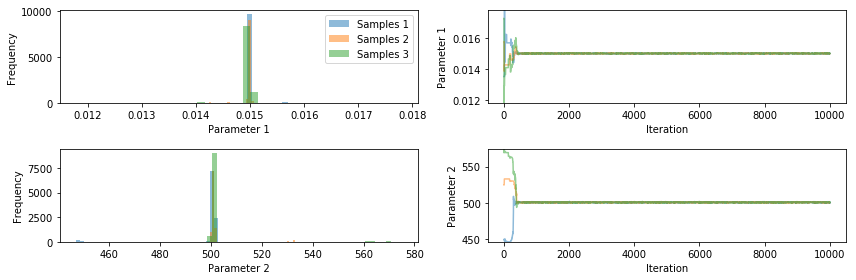

In [19]:
import pints.plot
pints.plot.trace(chains)
plt.show()

Based on this plot, it looks like the three chains become very similar after about 1000 iterations.
To be safe, we throw away the first 2000 samples and continue our analysis with the first chain.

In [20]:
chain = chains[0]
chain = chain[2000:]

We can also look for autocorrelation in the chains, using the [autocorrelation()](http://pints.readthedocs.io/en/latest/diagnostic_plots.html#pints.plot.autocorrelation) method. If everything went well, the samples in the chain should be relatively independent, so the autocorrelation should get quite low when the `lag` on the x-axis increases.

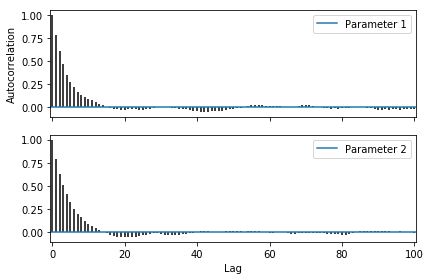

In [21]:
pints.plot.autocorrelation(chain)
plt.show()

Now we can inspect the inferred distribution by plotting histograms:

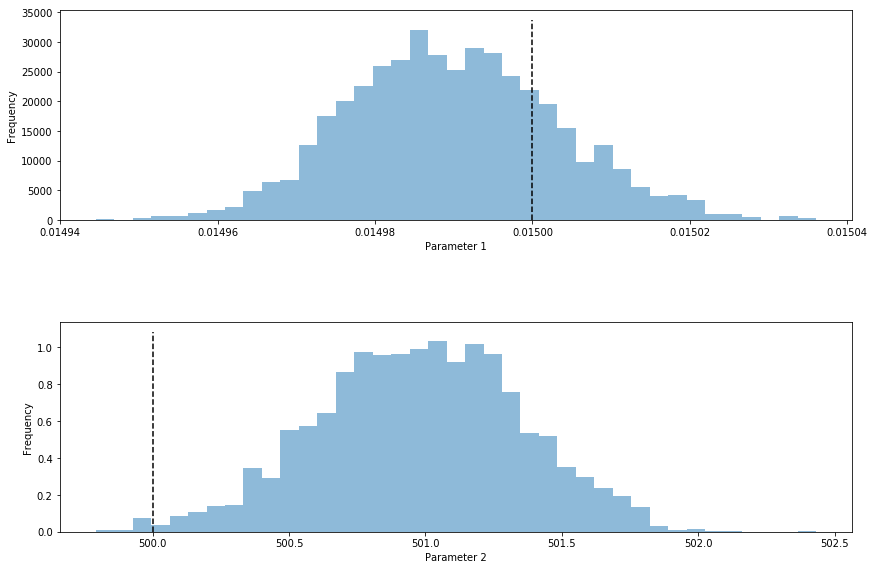

In [22]:
fig, axes = pints.plot.histogram([chain], ref_parameters=true_parameters)

# Show where the sample standard deviation of the generated noise is:
noise_sample_std = np.std(values - org_values)
#axes[-1].axvline(noise_sample_std, color='orange', label='Sample standard deviation of noise')
#axes[-1].legend()

fig.set_size_inches(14, 9)
plt.show()

Here we've analysed each parameter in isolation, but we can also look at correlations between parameters we found using the [pairwise()](http://pints.readthedocs.io/en/latest/diagnostic_plots.html#pints.plot.pairwise) plot.

To speed things up, we'll first apply some _thinning_ to the chain:

In [23]:
thinned_chain = chain[::10]

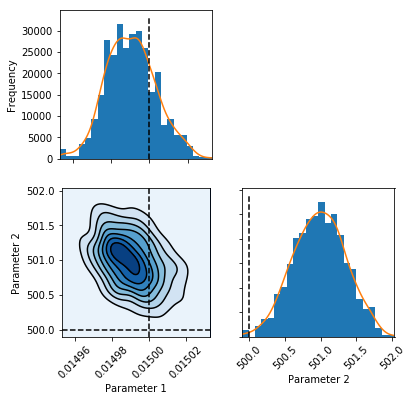

In [24]:
pints.plot.pairwise(thinned_chain, kde=True, ref_parameters=true_parameters)
plt.show()

As these plots show, we came pretty close to the original "true" values (represented by the blue line). 
But not exactly... Worse, the method seems to suggest a normal distribution but around the wrong point.
To find out what's going on, we can plot the log-posterior function near the true parameters:

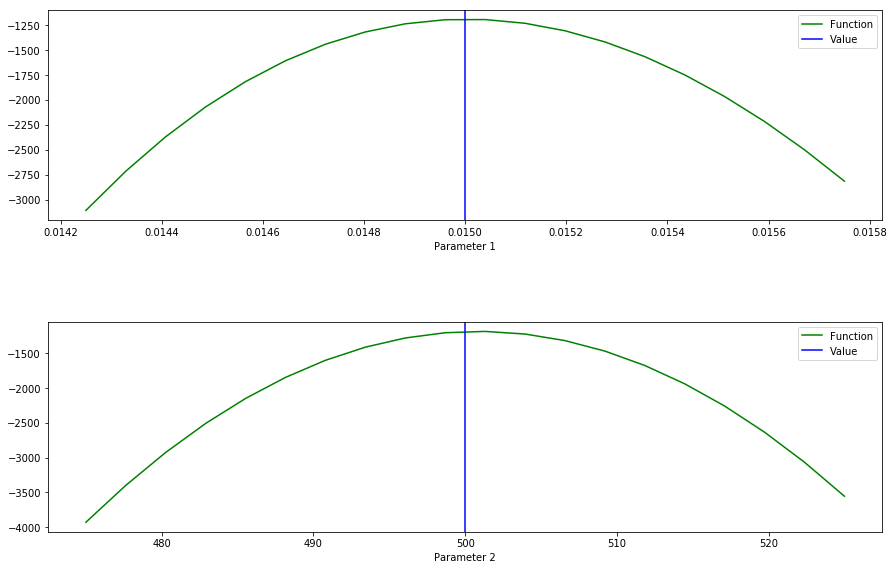

In [25]:
# Plot log-posterior function
fig, axes = pints.plot.function(log_posterior, true_parameters)

# Add a line showing the sample standard deviation of the generated noise
#axes[-1].axvline(noise_sample_std, color='orange', label='Sample standard deviation of noise')
#axes[-1].legend()

# Customise the figure size
fig.set_size_inches(14, 9)
plt.show()

As this plot (created entirely without MCMC!) shows, the MCMC method did well, but our estimate of the true parameters has become _biased_ by the stochastic noise! You can test this by increasing the number of sample points, which increases the size of the noise sample, and reduces the bias.

Finally, we can look at the bit that really matters: The model predictions made from models with the parameters we found (a _posterior predictive check_). Thes can be plotted using the [series()](http://pints.readthedocs.io/en/latest/diagnostic_plots.html#pints.plot.series) method.

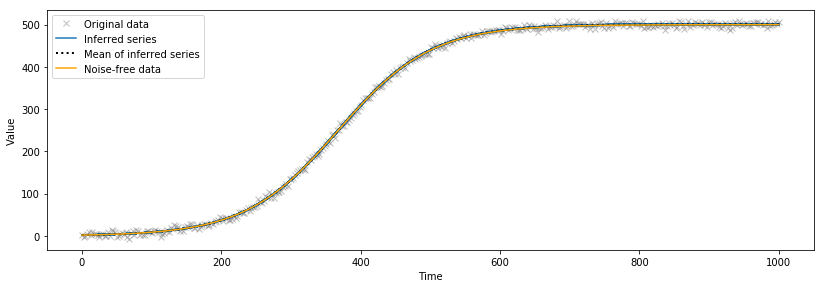

In [26]:
fig, axes = pints.plot.series(chain, problem)

# Customise the plot, and add the original, noise-free data
fig.set_size_inches(12,4.5)
plt.plot(times, org_values, c='orange', label='Noise-free data')
plt.legend()
plt.show()

-1194.459585559086
[1.49706135e-02 5.00000478e+02]
-1191.2167065079789


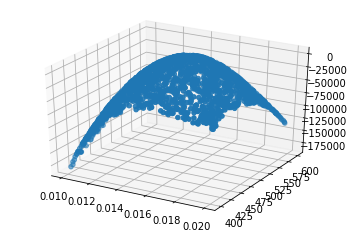

In [27]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D 

input_parameters = log_prior.sample(2000)
xs = [p[0] for p in input_parameters]
ys = [p[1] for p in input_parameters]
input_parameters[:5]

likelihoods = np.apply_along_axis(log_likelihood, 1, input_parameters)
likelihoods[:5]

print(max(likelihoods))
idx = list(likelihoods).index(max(likelihoods))
print(input_parameters[idx])
print(log_likelihood([0.015, 500]))

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xs, ys, list(likelihoods))
plt.show()

In [ ]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(input_parameters, likelihoods, test_size=0.3, random_state=0)

emu = pints.MultiLayerNN(log_likelihood, X_train, y_train, 
                          input_scaler=MinMaxScaler(), output_scaler=StandardScaler())
#emu.set_parameters(layers=6, neurons=64, hidden_activation='relu', activation='tanh', learning_rate=0.001)
emu.set_parameters(layers=6, neurons=64, hidden_activation='relu', activation='linear', learning_rate=0.0001)
hist = emu.fit(epochs=500, batch_size=32, X_val=X_valid, y_val=y_valid, verbose=0)
#emu.summary()

In [ ]:
emu([0.015, 500])

In [ ]:
emu([0.015, 505])

In [ ]:
log_likelihood([0.015, 500])

In [ ]:
# summarize history for loss
print(hist.history.keys())
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Learning curve')
plt.ylabel('MSE')
plt.xlabel('Epoch')
plt.legend(['training', 'validation'], loc='upper left')
plt.show()

In [ ]:
# summarize history for loss
print(hist.history.keys())
plt.plot(hist.history['mean_absolute_error'])
plt.plot(hist.history['val_mean_absolute_error'])
plt.title('Learning curve')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend(['training', 'validation'], loc='upper left')
plt.show()

In [ ]:
test_splits = 20 # number of splits along each axis
r_grid, k_grid, test_data = pints.generate_grid(bounds.lower(), 
                                                  bounds.upper(), 
                                                  test_splits)

model_prediction = pints.predict_grid(log_likelihood, test_data)

plt.figure(figsize = (10, 5))
surface(r_grid, k_grid, model_prediction, title = "True log-likelihood",
                     x_label = "growth rate (r)",
                     y_label = "carrying capacity (k)")

In [ ]:
emu_prediction = pints.predict_grid(emu, test_data)

plt.figure(figsize = (10, 5))
ax = surface(r_grid, 
             k_grid, 
             emu_prediction, 
             title = "Multi-layer NN emulator log-likelihood",
             x_label = "growth rate (r)",
             y_label = "carrying capacity (k)")

In [ ]:
chain = chains[0]
emu_prediction = np.apply_along_axis(emu, 1, chain).flatten()
model_prediction = np.apply_along_axis(log_likelihood, 1, chain).flatten()
diffs = np.abs(model_prediction - emu_prediction)

iters = np.linspace(0, 10000, len(chain))
plt.figure(figsize=(10, 5))
plt.title("Emulator and model absolute differences along a chain of MCMC")
plt.xlabel("Number of iterations")
plt.ylabel("Likelihood")
plt.plot(iters, diffs, color = "Black")
plt.show()

diffs[-1]

In [ ]:
print(emu_prediction)

In [ ]:
log_posterior_emu = pints.LogPosterior(emu, log_prior)
xs = [
    np.array(true_parameters) * 0.9,
    np.array(true_parameters) * 1.05,
    np.array(true_parameters) * 1.15,
]

In [ ]:
chains_emu = pints.mcmc_sample(log_posterior_emu, 3, xs)

In [ ]:
pints.plot.trace(chains_emu)
plt.show()

In [ ]:
pints.plot.trace(chains)
plt.show()

In [ ]:
chain_emu = chains_emu[0]
chain_emu = chain_emu[2000:]
chain = chain[2000:]

In [ ]:
fig, axes = pints.plot.histogram([chain_emu, chain], ref_parameters=true_parameters)
fig.set_size_inches(14, 9)
plt.show()

In [ ]:
thinned_chain_emu = chain_emu[::10]
pints.plot.pairwise(thinned_chain_emu, kde=True, ref_parameters=true_parameters)
plt.show()

In [ ]:
pints.plot.pairwise(thinned_chain, kde=True, ref_parameters=true_parameters)
plt.show()

In [ ]:
print(len(chain))
print(len(chain_emu))
emu_prediction = np.apply_along_axis(emu, 1, chain_emu).flatten()
model_prediction = np.apply_along_axis(log_likelihood, 1, chain[:8000]).flatten()
diffs = np.abs(model_prediction - emu_prediction)

iters = np.linspace(0, 10000, len(chain_emu))
plt.figure(figsize=(10, 5))
plt.title("Emulator and model absolute differences along a chain of MCMC")
plt.xlabel("Number of iterations")
plt.ylabel("Likelihood")
plt.plot(iters, diffs, color = "Black")
plt.show()

diffs[-1]

In [ ]:
# Plot log-posterior function
fig, axes = pints.plot.function(log_posterior_emu, true_parameters)

# Customise the figure size
fig.set_size_inches(14, 9)
plt.show()